## Part. 1 - Setup + Fit each Task
Using the same dataset, MNIST_TINY (only 3's and 7's, n=700). Learning tasks include:

 - classification
 - regression (of one/multiple scalars)
 - point regression (of one/multiple points)
 - bounding boxes **TODO**

We'll setup distinct `DataBlock`'s and `Learner`'s for each, and demonstrate they can be run through fitting cycles. Later on we develop fitting strategies for each of these.

In [3]:
import os, sys
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1

### Get Data + View It
We build some simple features on each image, within `build_df`. 

Features use basic computer vision like "topleft-most point" or "sum of all pixel values" which then become targets for learners below.

In [4]:
path = untar_data(URLs.MNIST_TINY)

In [5]:
df = build_df(path)
df.head(2)

,fn,digit_class,scalar_top,scalar_bottom,scalar_pxsum,point_topleft_x,point_topleft_y,point_center_x,point_center_y
0,/train/3/7.png,3,5,25,35867,11,5,15,14
1,/train/3/7030.png,3,4,24,29717,9,4,14,13



    Display items with corresponding Y's:
    Scalar targets are printed above the items
    Point targets are shown on image: (Red: topleft, Green: center)
    


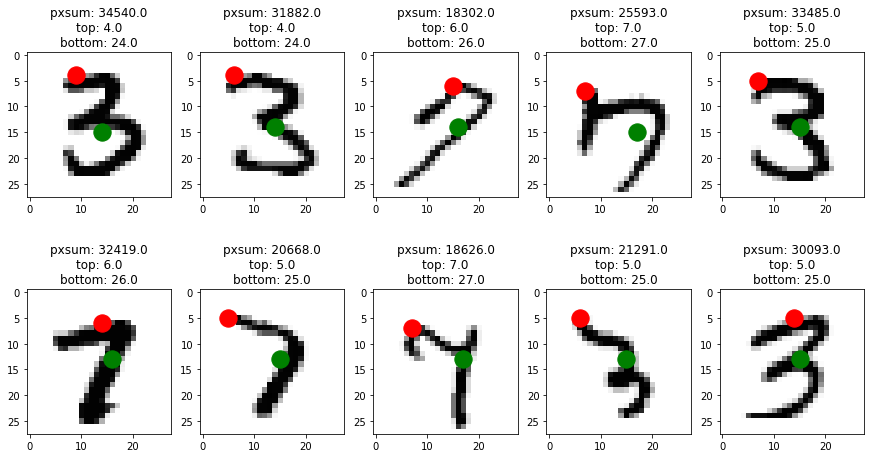

In [6]:
eda_fig_1(df, path)

### Setup Data Elements
All `DataLoaders` are built from `df` but each DataBlock has differences in:
 - `XXXXXBlock` for y
 - `n_inp` parameter (if nec.)
 - `ColReader` used for get_y

These differences get used implictly downsteam when initializing the CNN Learner on these datasets.

In [7]:
db_cls   =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                               CategoryBlock), 
                       splitter=RandomSplitter(),
                       get_x=ColReader('fn', pref=path),
                       get_y=ColReader(['digit_class'])
                      )

db_reg_1 =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                               RegressionBlock), 
                       splitter=RandomSplitter(),
                       get_x=ColReader('fn', pref=path),
                       get_y=ColReader(['scalar_pxsum'])
                      )

db_reg_2 =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                               RegressionBlock(n_out=2)), 
                       splitter=RandomSplitter(),
                       get_x=ColReader('fn', pref=path),
                       get_y=ColReader(['scalar_top', 'scalar_bottom'])
                      )

db_pnt_1 =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                               PointBlock), 
                       splitter=RandomSplitter(),
                       get_x=ColReader('fn', pref=path),
                       get_y=ColReader(['point_topleft_x', 
                                        'point_topleft_y'])
                      )

db_pnt_2 =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                               PointBlock), 
                       splitter=RandomSplitter(),
                       get_x=ColReader('fn', pref=path),
                       get_y=ColReader(['point_topleft_x', 
                                        'point_topleft_y',
                                        'point_center_x',
                                        'point_center_y']),
                      n_inp=1,
                      )

In [8]:
dls_cls =    db_cls.dataloaders(df)
dls_reg_1 =  db_reg_1.dataloaders(df)  
dls_reg_2 =  db_reg_2.dataloaders(df)  
dls_pnt_1 =  db_pnt_1.dataloaders(df)  
dls_pnt_2 =  db_pnt_2.dataloaders(df)

##### Note: `vocab` property is off for non-classifcation

In [9]:
print(dls_cls.vocab)

try: print(dls_reg_1.vocab)
except: print('regression task has no vocab')

(#2) [3,7]
regression task has no vocab


##### Note:  different `y'`s for each (same `x`'s)

In [10]:
(dls_cls.dataset[:2],
'------',
dls_reg_1.dataset[:2],
'-----',
dls_reg_2.dataset[:2],
'-----',
dls_pnt_1.dataset[:2],
'-----',
dls_pnt_2.dataset[:2],)

([(PILImageBW mode=L size=28x28, TensorCategory(0)),
  (PILImageBW mode=L size=28x28, TensorCategory(0))],
 '------',
 [(PILImageBW mode=L size=28x28, tensor(24962.)),
  (PILImageBW mode=L size=28x28, tensor(42773.))],
 '-----',
 [(PILImageBW mode=L size=28x28, tensor([ 6., 26.])),
  (PILImageBW mode=L size=28x28, tensor([ 8., 28.]))],
 '-----',
 [(PILImageBW mode=L size=28x28, TensorPoint([[9., 7.]])),
  (PILImageBW mode=L size=28x28, TensorPoint([[8., 7.]]))],
 '-----',
 [(PILImageBW mode=L size=28x28,
   TensorPoint([[10.,  8.],
           [17., 15.]])),
  (PILImageBW mode=L size=28x28,
   TensorPoint([[ 7.,  7.],
           [17., 14.]]))])

##### Note: the `y` is represented differently in the `DataLoader` from the `Dataset`
This is the encoding happening from raw-dataset -> endoed dataloader

Categorical get a category transform, regression remains unscaled and points get scaled \[-1,1], in a `TensorPoint`.

In [11]:
batch_cls   = dls_cls.one_batch()
batch_reg_1 = dls_reg_1.one_batch()
batch_reg_2 = dls_reg_2.one_batch()
batch_pnt_1 = dls_pnt_1.one_batch()
batch_pnt_2 = dls_pnt_2.one_batch()

In [12]:
(batch_cls[1][:3],
'------',
batch_reg_1[1][:3],
'------',
batch_reg_2[1][:3],
'------',
batch_pnt_1[1][:3],
'------',
batch_pnt_2[1][:3])

(tensor([1, 0, 1]),
 '------',
 tensor([26076., 11894., 24787.]),
 '------',
 tensor([[ 4., 24.],
         [ 4., 24.],
         [ 7., 27.]]),
 '------',
 tensor([[[-0.4286, -0.5714]],
 
         [[-0.2857, -0.4286]],
 
         [[-0.3571, -0.5000]]]),
 '------',
 tensor([[[-0.0714, -0.6429],
          [ 0.0714,  0.0000]],
 
         [[-0.2143, -0.5714],
          [ 0.1429,  0.0000]],
 
         [[-0.3571, -0.6429],
          [ 0.0714, -0.0714]]]))

##### We can also see the encoding/decoding in a `batch` or unsing `decode_batch`

In [15]:
b_decoded = dls_pnt_2.decode_batch(batch_pnt_2, max_n=64)

In [37]:
i = 3
(type(b_decoded[i][0]),
 '------------------------------',
 type(batch_pnt_2[0][i]))

(fastai2.torch_core.TensorImageBW,
 '------------------------------',
 torch.Tensor)

In [34]:
i = 3
y_decoded = b_decoded[i][1]
y_encoded = batch_pnt_2[1][i]

( (type(y_decoded),' +++ ', y_decoded),
  '---------',
  (type(y_encoded), ' +++ ', y_encoded))

((fastai2.vision.core.TensorPoint,
  ' +++ ',
  TensorPoint([[ 7.,  7.],
          [17., 14.]])),
 '---------',
 (torch.Tensor,
  ' +++ ',
  tensor([[-0.5000, -0.5000],
          [ 0.2143,  0.0000]])))

##### TODO How To: convert integer points to flowfield points

##### TODO: show how auto scaling takes pace via tranfroms

### Build Learners and Fit

In [38]:
learn_cls = cnn_learner(dls_cls, resnet18, pretrained=True)
learn_cls.fit(1)

epoch,train_loss,valid_loss,time
0,0.839709,0.281085,00:05


In [90]:
learn_reg_1 = cnn_learner(dls_reg_1, resnet18, pretrained=True,
                          y_range = (0, (255*(28**2)))
                          )
learn_reg_1.fit(1)

epoch,train_loss,valid_loss,time
0,8595555328.000000,7485923328.000000,00:05


In [104]:
# unclear how to set y_range in this case
learn_reg_2 = cnn_learner(dls_reg_2, resnet18, pretrained=True,)
learn_reg_2.fit(1)

epoch,train_loss,valid_loss,time
0,347.028351,339.177155,00:05


In [44]:
learn_pnt_1 = cnn_learner(dls_pnt_1, resnet18, pretrained=True)
learn_pnt_1.fit(1)

epoch,train_loss,valid_loss,time
0,3.890149,0.267073,00:06


In [45]:
learn_pnt_2 = cnn_learner(dls_pnt_2, resnet18, pretrained=True)
learn_pnt_2.fit(1)

epoch,train_loss,valid_loss,time
0,4.000129,0.325454,00:05


##### Note: the pretrained resnet arch induces a num-channels change to input `dl`
This occurs when passing dls into `cnn_learner(dls,..., pretrained=True` which has already occured for `dls_reg_1` in the cell above, but not for tmp_dl, even tough they were built the same way.

This needs to occur for the pretrained architecture to work witht eh input size.

In [118]:
tmp_dls = db_reg_1.dataloaders(df)

pre_x0  = tmp_dls.one_batch()[0][0]
post_x0 = dls_reg_1.one_batch()[0][0]

(pre_x0.shape, post_x0.shape)

(torch.Size([1, 28, 28]), torch.Size([3, 28, 28]))

##### Note the model arch get's changed at the last two layer

In [101]:
learn_reg_1.model[1][7:]

Sequential(
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1, bias=False)
  (9): SigmoidRange(low=0, high=199920)
)

In [106]:
learn_reg_2.model[1][7:]

Sequential(
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

### Model Evaluation + Prediction

In [91]:
interp_reg_1 = Interpretation.from_learner(learn_reg_1)

In [94]:
interp_reg_1.top_losses(3)

torch.return_types.topk(
values=tensor([1.8975e+10, 1.7620e+10, 1.7610e+10]),
indices=tensor([113,  52, 120]))